#Skin Lesion Classification with Deep Learning

In this notebook we will train Image Classification models on the original ISIC2017 dataset

The dataset contains: 


*   Training set: 2000 images
*   Validation set: 150 images
*   Test set: 600 images






• Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 • Tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter

* Check GPU type

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun 15 17:18:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Libraries**



In this section we import the packages and libraries for future use

In [ ]:
!pip install opencv-python-headless==4.5.2.52

!pip install git+https://github.com/albumentations-team/albumentations

In [ ]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
from skimage import io
from typing import Optional, Sequence
import copy
import time
import logging
import sys

# Sci-kit learn
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight

#Pytorch 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import albumentations as A

# Some progress bar libraries
from tqdm import tqdm

# **Helper functions**

In this section we define different utils/helper functions that will be usefull for the rest of the notebook

##  *Visualization*

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor.
       A Function that uses Matplotlib's PyPlot to show an image stored in a pytorch tensor 
       inputs: inp => image stored in tensor 
               title => title to be displayed with the image 
       returns: None

    """
    inp = inp.numpy().transpose((1, 2, 0))
    #denormalize
    mean = np.array([0.7180, 0.6071, 0.5638])
    std = np.array([0.1015, 0.1216, 0.1438])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
def visualize_model(model, loader, device, num_images=6):
    """Imshow for Tensor.
       Function to visualize some images and their predictions with the corresponding ground truth labels
       inputs: model => model  to predict the classes  
               loader => PyTorch dataloader to get the images 
               device => CUDA or CPU
               num_images => the number of images to show
       returns: None

    """
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for batch in loader:
            inputs = batch["image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {preds[j]}')
                imshow(inputs.cpu().data[j])
                print(f'Actual: {labels[j]}, predicted: {preds[j]}')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Loss function

Here we define loss functions that are not available in PyTorch's nn module

### Focal Loss

In [ ]:
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

## Models

In the following, we create a function that creates an image classification model from torchvision.models and modifies its last layer (the classifier) to have 3 outputs instead of 1000. 

In [ ]:
def make_densenet(pretrained = True):
  """ Function to create a DenseNet model with 3 output neurones"""
  model = models.densenet121(pretrained=pretrained)
  num_ftrs = model.classifier.in_features
  # Here the size of each output sample is set to 3, the number of types of lesions that we have.
  model.classifier = nn.Linear(num_ftrs, 3)
  model = model.to(DEVICE)
  return model

In [ ]:
def make_vitb16(pretrained = True):
  """ Function to create a ViT model with 3 output neurones"""
  vit = models.vit_b_16(pretrained = True)
  vit.heads =  nn.Sequential(
    nn.Linear(in_features=768, out_features=3, bias=True) # replace 1000 output layer with 3-output lineaar layer
  )
  vit = vit.to(DEVICE)
  return vit

In [ ]:
def make_convnext(pretrained = True):
  """ Function to create a ConvNeXt model with 3 output neurones"""
  model = models.convnext_small(pretrained=pretrained)
  model.classifier[2] = nn.Linear(in_features=768, out_features=3, bias=True) # replace 1000 output layer with 3-output lineaar layer
  model = model.to(DEVICE)
  return model

## Training

In [ ]:
# Training function
def train_model(model, # model to be trained
                dataloaders, # dict of 2 dataloaders one for train another for validation
                criterion, # loss function
                optimizer, # optimization algorithm to be used
                scheduler, # LR scheduler
                early_stop_patience=10, # Early stop if no improvement in the loss after this much epochs
                num_epochs=25, # maximum number of epochs 
                writer_path= ''): # path for tensorboard 
    """ Function to train a model """
    since = time.time()

    writers = {
        'train': SummaryWriter(writer_path + '/log'),
        'val': SummaryWriter(writer_path + '/log_val')
    }

    best_model_wts = copy.deepcopy(model.state_dict()) # initialize best weights with initial model weights
    best_loss = 1e8 # as bad as it gets 
    best_bma = 0.0 # as bad as it gets 
    early_stop_c = 0 # initialize early stopping count

    for epoch in range(num_epochs): # iterate over the whole dataset (epoch)
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']: 
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0 # keep track of epoch loss
            running_labels = [] # list to hold labels over all the epoch
            running_preds = [] # list to hold the model predictions over all the epoch

            # Iterate over data.
            for batch in dataloaders[phase]: # iterate over each batch in the loader

                inputs = batch["image"].to(DEVICE) # fetch data and move to GPU/cPU
                labels = batch["label"].to(DEVICE) # fetch data and move to GPU/cPU

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # formward pass
                    _, preds = torch.max(outputs, 1) # assume class with max probability as output
                    loss = criterion(outputs, labels) # calculate the loss of the batch

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() # backpropagation
                        optimizer.step() # update weights 

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_labels = running_labels + labels.int().cpu().tolist()
                running_preds = running_preds + preds.int().cpu().tolist()


            epoch_loss = running_loss / dataset_sizes[phase] # average loss of the epoch
            epoch_acc = accuracy_score(running_labels, running_preds) # accuracy of the epoch
            epoch_bma = balanced_accuracy_score(running_labels, running_preds) # balanced multiclass accuracy of the epoch

            if phase == 'val':
              scheduler.step(epoch_loss) # Update LR dynamically 
              lr_ = optimizer.param_groups[0]['lr'] # save current learning rate to writer
              writers['train'].add_scalar('info/lr', lr_, epoch)

            # print(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, BMA: {epoch_bma:.4f}')
            logging.info( '%s epoch %d : loss : %.4f, acc: %.4f, bma: %.4f' %
                (phase, epoch+1, epoch_loss, epoch_acc, epoch_bma))
            
            # save stats to writer for tracking
            writers[phase].add_scalar('info/loss', epoch_loss, epoch)
            writers[phase].add_scalar('info/acc', epoch_acc, epoch)
            writers[phase].add_scalar('info/bma', epoch_bma, epoch)

            # update best parameters
            if phase == 'val':
              if epoch_loss < best_loss: # a new best val loss achieved 
                best_loss = epoch_loss # update the best loss
                early_stop_c = 0 #new minimum found, reset ES counter
              else:
                early_stop_c += 1 # increment ES counter

              if epoch_bma > best_bma: # new best bma achieved
                best_bma = epoch_bma  # update bma tracker
                best_model_wts = copy.deepcopy(model.state_dict()) # update best weights tracker 

        if early_stop_c > early_stop_patience: # if no val loss minimum was found in the last ES Patience epochs then stop training
            print(f'EARLY STOP AFTER {epoch + 1} EPOCHS')         
            break   

        print()
    # print statistics 
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:4f}')
    print(f"Best val BMA: {best_bma}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    writers['train'].close()
    writers['val'].close()
    return model

## Testing

In [ ]:
def test_model(model,  # model to be tested
               loader, # test loader
               device, # Cuda or CPU
               criterion): # loss function

    """ Function to test a model's performance on the test set 
        inputs: model => model to be tested
                loader => test loader 
                device => Cuda or CPU
                criterion => objective function

        returns: test loss, test accuracy and test bma
    """           
    since = time.time()

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    running_labels = []
    running_preds = []

    # Iterate over data.
    with torch.no_grad():
        for batch in loader:
            inputs = batch["image"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            running_labels = running_labels + labels.int().cpu().tolist()
            running_preds = running_preds + preds.int().cpu().tolist()

        test_loss = running_loss / dataset_sizes['test'] 
        test_bma = balanced_accuracy_score(running_labels, running_preds)
        test_acc = accuracy_score(running_labels, running_preds)
        print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}, BMA: {test_bma:.4f}')
    
        time_elapsed = time.time() - since
        print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        model.train()

        return test_loss, test_acc, test_bma

# **Dataset Definition and Split**

## Sampler

This is a custom sampler to be passed as a parameter to the dataloader. It randomly samples the dataset to have a balanced number of images in each class. In the 'over' case the new number of images in each class will be equal to the number of images in the 'majority' class (benign). The minority classes will be sampled with replacement, in the case of 'mean' the new number of images in each class will be equal to the 'mean' of the numbers of samples in each class. in the case of 'under' the new number of images in each class will be equal to the number of images in the 'minority' class (seborrheic keratosis).

In [ ]:
from typing import Callable
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices: a list of indices
        num_samples: number of samples to draw
        callback_get_label: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices: list = None, num_samples: int = None, callback_get_label: Callable = None,
                 replacement=True):
        # if indices is not provided, all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        self.replacement = replacement

        # distribution of classes in the dataset
        df = pd.DataFrame()
        df["label"] = self._get_labels(dataset)
        df.index = self.indices
        df = df.sort_index()

        label_to_count = df["label"].value_counts()

        weights = 1.0 / label_to_count[df["label"]]

        self.weights = torch.DoubleTensor(weights.to_list())

    def _get_labels(self, dataset):
        if self.callback_get_label:
            return self.callback_get_label(dataset)
        elif isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels.tolist()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return [x[1] for x in dataset.imgs]
        elif isinstance(dataset, torchvision.datasets.DatasetFolder):
            return dataset.samples[:][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[:][1]
        elif isinstance(dataset, torch.utils.data.Dataset):
            return dataset.get_labels()
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in
                torch.multinomial(self.weights, self.num_samples, replacement=self.replacement))

    def __len__(self):
        return self.num_samples

## Custom ISIC2017 Dataset

Next, we create a custom Pytorch dataset class for ISIC2017 data

In [ ]:
# Parameters 
# Please change to the corresponding path if not the same in your device
# Image directories
train_img_folder = '/content/drive/MyDrive/MRTYUTeam/Dataset/images'
val_img_folder = '/content/drive/MyDrive/MRTYUTeam/Dataset/validation_images'
test_img_folder = '/content/drive/MyDrive/MRTYUTeam/Dataset/test_images'

# CSV paths
train_csv_path = '/content/drive/MyDrive/MRTYUTeam/Dataset/train_2000.csv'
val_csv_path = '/content/drive/MyDrive/MRTYUTeam/Dataset/validation_150.csv'
test_csv_path = '/content/drive/MyDrive/MRTYUTeam/Dataset/test_600.csv'

#number of samples in each set
dataset_sizes = {
    'train': 2000,
    'val':150,
    'test':600
}

In [ ]:
class ISIC2017Dataset(Dataset):
    """ISIC2017 dataset"""

    def __init__(self, csv_file, image_folder, img_transform=None, augment = False):
        """
        Args:
            csv_file (string): Path to the csv file with image paths & classification labels.
            image_folder (string): Path to the folder where the PNG images are located
            img_transform (callable, optional): Optional transform to be applied on a sample.
            augment (boolean): Whether to perform data augmentation or not
        """
        self.df = pd.read_csv(csv_file).drop("Unnamed: 0", axis = 1) # pandas dataframe containing the image IDs and classification labels  
        self.image_folder = image_folder # path to the folder containing the original images 
        self.img_transform = img_transform # image transform for the images
        self.augment = augment # whether to perform data augmentation or not
        self.labels = self.df["label"].values.tolist()
        

    def __len__(self):
        return len(self.df) # return the number of images in the dataset

    
    def get_labels(self):
        return self.labels # return the number of images in the dataset


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
       
        img_id = '/' + self.df.iloc[idx]['image_id'] # obtain image file name start 
        
        img_path = self.image_folder+img_id + '.jpg' # file path of the original image 
        image = Image.open(img_path)  # open the original image as RGB

        label = self.df.iloc[idx]['label'] # get the image's correct class

        # If augment = T perform data augmentation: 
        if self.augment:
          image_np = np.array(image) # albumentations only works with np arrays so convert from PIL 
          aug_transform = A.Compose(
                                      [   
                                          A.SmallestMaxSize(max_size=260),
                                          A.RandomResizedCrop(height=256, width=256, p = 0.7, scale=(0.4, 1.0), ratio=(0.75, 4/3)),
                                          A.Affine(scale=(0.8, 1.2), rotate=(0.0, 90.0), shear=(0.0, 20.0), mode=1, p=0.8),
                                          A.Flip(p=0.9),
                                          A.ColorJitter(brightness=[0.7, 1.3], contrast=[0.7, 1.3], saturation=[0.9, 1.1], hue=0.05, p=0.6),
                                      ]
                                  )
          augmentations = aug_transform(image=image_np) # apply the transform 
          image = Image.fromarray(augmentations["image"]) # convert back to PIL to use torchvision transforms

        # If a transform is provided apply it (Preprocessing)
        if self.img_transform:
            image = self.img_transform(image)

        # return the image, the segmentation label
        return {
            'image': image,
            'label': label,
      }

## Prepare data

In [ ]:
# function to find the number of samples in the balanced trainning loader
def get_samples_count(y, sampling_technique):
        """
          function to find the number of samples in the balanced trainning loader
          inputs: y => list of labels 
                  sampling technique => 'mean' or 'over' or 'under'

          returns: mean_samples = 
                                  mean of the number of samples in each class if 'mean'
                                  #samples in the majority class for each class if 'over'
                                  #samples in the minority class for each class if 'under' 
        """
        unique, counts = np.unique(y, return_counts=True) # number of samples in each class
       
        if sampling_technique == 'mean':
            mean_samples = np.mean(counts)*3 # return the mean of samples from each class 
        elif sampling_technique == 'over':
            mean_samples = np.max(counts)*3 # return the #samples in the majority class for each class 
        elif sampling_technique == 'under':
            mean_samples = np.min(counts)*3 # return the #samples in the minority class for each class
        else:
            raise Exception("Error: Sampling Technique not implemented")
        return int(mean_samples)

In [ ]:
# Parameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used

NEW_SIZE = 256

# Calculated from the original training set 
mu = [0.7079, 0.5916, 0.5469]# mean
std = [0.0937, 0.1113, 0.1257]# Standard deviation

TRAIN_BATCH_SIZE = 10
TEST_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
NUM_WORKERS = 2

#### Data Transforms

In [ ]:
# Transforms for preprocessing, we will use the same for all datasets here
img_transforms = transforms.Compose([
                                      transforms.Resize(NEW_SIZE+4),
                                      transforms.CenterCrop(NEW_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean= mu, std=std)
                                  ]) 

#### Datasets 

In [ ]:
# Training dataset, will contain 3000 images after augmentation
isic_train = ISIC2017Dataset(csv_file=train_csv_path,
                             image_folder= train_img_folder,
                             img_transform = img_transforms,
                             augment = True) # apply data augmentation to the training set

In [ ]:
# Validation dataset, will contain 300 images from the augmented test set
isic_val = ISIC2017Dataset(csv_file=val_csv_path, 
                            image_folder= val_img_folder, 
                            img_transform = img_transforms,
                            augment=False)


In [ ]:
# Test dataset, will contain the original 1000 images from ISIC2017
isic_test = ISIC2017Dataset(csv_file=test_csv_path, 
                            image_folder= test_img_folder, 
                            img_transform = img_transforms,
                            augment=False)

#### Data Loaders

In [ ]:
# use sklearn to obtain class weights to give more importance to minority classes
y = isic_train.get_labels()
class_weights= class_weight.compute_class_weight(class_weight = 'balanced', classes= np.unique(y), y= np.array(y))
class_weights =  torch.tensor(class_weights).float().to(DEVICE)

In [ ]:
class_weights

tensor([0.4859, 1.7825, 2.6247], device='cuda:0')

In [ ]:
# Balanced training dataloader
mean_samples = get_samples_count(isic_train.get_labels(), 'under') # perform undersampling 
data_sampler = ImbalancedDatasetSampler(isic_train, indices=None, num_samples=mean_samples, replacement = True)
train_loader_balanced = DataLoader(isic_train, sampler=data_sampler, num_workers=NUM_WORKERS,
                             batch_size=TRAIN_BATCH_SIZE) 


In [ ]:
mean_samples

762

In [ ]:
# dataloaders with the original number of samples in the dataset
train_loader = DataLoader(isic_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(isic_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader = DataLoader(isic_test, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKERS)

In [ ]:
dataloaders = {"train": train_loader,
              "val": val_loader}

dataloaders_balanced = {"train": train_loader_balanced,
                        "val": val_loader}

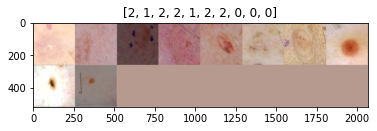

In [ ]:
# Get a batch of training data
batch = next(iter(train_loader_balanced))
inputs = batch["image"]
classes = batch["label"]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x.item() for x in classes])

# Training & Evaluation

## 1. DenseNet

### Train

#### With Focal Loss

##### With SGD

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/Densenet/densenest_fl_sgd_2.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/Densenet'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4 # base learning rate
LR_PATIENCE = 5 # if no val loss improvement in this much epochs update the LR
ES_PATIENCE = 10 # if no improvement in val loss after this much epochs stop training
EPOCHS = 100 # maximum number of epochs 
WD = 1e-6 # weight decay

In [ ]:
densenet = make_densenet(True) # create the model

criterion = FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True) # use Focal loss with the class weights obtained from sklearn

optimizer = optim.SGD(densenet.parameters(), lr = LR, weight_decay=WD, momentum = 0.9) # use SGD algorithm for optimization

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.25, mode="min") # use dynamic learning rate scheduling 

In [ ]:
logging.info('Model:Densenet, LR: 1e-4, LR patience = 5, loss: Focal, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-6, momentum = 0.9')

Model:Densenet, LR: 1e-4, LR patience = 5, loss: Focal, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-6, momentum = 0.9


In [ ]:
# train the model
densenet = train_model(densenet, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.4738, acc: 0.3760, bma: 0.4235
val epoch 1 : loss : 0.6199, acc: 0.5533, bma: 0.5352

Epoch 2/100
----------
train epoch 2 : loss : 0.4199, acc: 0.4810, bma: 0.5131
val epoch 2 : loss : 0.5281, acc: 0.5133, bma: 0.5342

Epoch 3/100
----------
train epoch 3 : loss : 0.3908, acc: 0.5100, bma: 0.5590
val epoch 3 : loss : 0.4963, acc: 0.5400, bma: 0.5718

Epoch 4/100
----------
train epoch 4 : loss : 0.3718, acc: 0.5515, bma: 0.5852
val epoch 4 : loss : 0.4552, acc: 0.5200, bma: 0.5258

Epoch 5/100
----------
train epoch 5 : loss : 0.3628, acc: 0.5595, bma: 0.5951
val epoch 5 : loss : 0.4447, acc: 0.6200, bma: 0.6009

Epoch 6/100
----------
train epoch 6 : loss : 0.3423, acc: 0.5740, bma: 0.6145
val epoch 6 : loss : 0.4386, acc: 0.6533, bma: 0.6295

Epoch 7/100
----------
train epoch 7 : loss : 0.3429, acc: 0.5650, bma: 0.6083
val epoch 7 : loss : 0.4156, acc: 0.6467, bma: 0.6184

Epoch 8/100
----------
train epoch 8 : loss : 0.3311, acc: 0.6

Test

In [ ]:
# calculate loss, acc and bma on the test set
test_loss, test_acc, test_bma = test_model(densenet, test_loader, DEVICE, criterion)

Test Loss: 0.3083 Acc: 0.6433, BMA: 0.6839
Testing complete in 3m 36s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.3083, acc: 0.6433, bma: 0.6839


Show some results

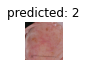

Actual: 2, predicted: 2


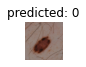

Actual: 0, predicted: 0


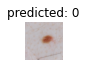

Actual: 0, predicted: 0


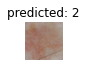

Actual: 2, predicted: 2


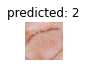

Actual: 2, predicted: 2


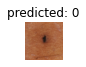

Actual: 0, predicted: 0


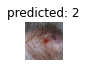

Actual: 0, predicted: 2


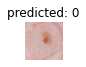

Actual: 0, predicted: 0


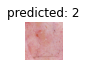

Actual: 2, predicted: 2


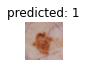

Actual: 2, predicted: 1


In [ ]:
# show some example results 
visualize_model(densenet, test_loader, DEVICE, num_images=10)

##### With ADAM

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/Densenet/densenest_fl_adam.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/Densenet'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-8

In [ ]:
densenet = make_densenet(True)

criterion = FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True)

optimizer = optim.Adam(densenet.parameters(), lr = LR, weight_decay=WD) # use Adam optimization algorithm instead of SGD

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.5, mode="min")

In [ ]:
logging.info('Model:Densenet, LR: 1e-4, LR patience = 7, loss: Focal, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8')

Model:Densenet, LR: 1e-4, LR patience = 7, loss: Focal, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8


In [ ]:
densenet = train_model(densenet, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.3960, acc: 0.5155, bma: 0.5456
val epoch 1 : loss : 0.4119, acc: 0.6333, bma: 0.5835

Epoch 2/100
----------
train epoch 2 : loss : 0.3366, acc: 0.5790, bma: 0.6013
val epoch 2 : loss : 0.3982, acc: 0.6933, bma: 0.6811

Epoch 3/100
----------
train epoch 3 : loss : 0.3000, acc: 0.6100, bma: 0.6549
val epoch 3 : loss : 0.3281, acc: 0.7133, bma: 0.7154

Epoch 4/100
----------
train epoch 4 : loss : 0.2955, acc: 0.6145, bma: 0.6562
val epoch 4 : loss : 0.2977, acc: 0.6867, bma: 0.7083

Epoch 5/100
----------
train epoch 5 : loss : 0.2630, acc: 0.6595, bma: 0.7002
val epoch 5 : loss : 0.2689, acc: 0.7267, bma: 0.7254

Epoch 6/100
----------
train epoch 6 : loss : 0.2426, acc: 0.6670, bma: 0.7073
val epoch 6 : loss : 0.2426, acc: 0.7667, bma: 0.7574

Epoch 7/100
----------
train epoch 7 : loss : 0.2481, acc: 0.6600, bma: 0.7018
val epoch 7 : loss : 0.2693, acc: 0.7533, bma: 0.7147

Epoch 8/100
----------
train epoch 8 : loss : 0.2565, acc: 0.6

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(densenet, test_loader, DEVICE, criterion)

Test Loss: 0.3792 Acc: 0.7700, BMA: 0.7275
Testing complete in 3m 25s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.3792, acc: 0.7700, bma: 0.7275


Show some results

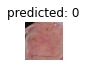

Actual: 2, predicted: 0


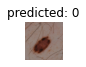

Actual: 0, predicted: 0


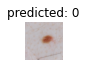

Actual: 0, predicted: 0


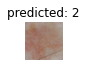

Actual: 2, predicted: 2


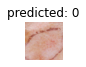

Actual: 2, predicted: 0


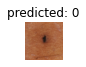

Actual: 0, predicted: 0


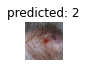

Actual: 0, predicted: 2


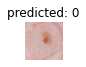

Actual: 0, predicted: 0


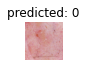

Actual: 2, predicted: 0


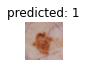

Actual: 2, predicted: 1


In [ ]:
visualize_model(densenet, test_loader, DEVICE, num_images=10)

#### With Weighted Cross Entropy 

##### With SGD

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/Densenet/densenest_wce_sgd.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/Densenet'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 15

EPOCHS = 100
WD = 1e-8

In [ ]:
densenet = make_densenet(True)

criterion = nn.CrossEntropyLoss(weight=class_weights) # use Weighted cross entropy loss instead of focal loss

optimizer = optim.SGD(densenet.parameters(), lr = LR, weight_decay=WD, momentum = 0.9)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.5, mode="min")

In [ ]:
logging.info('Model:Densenet, LR init: 1e-4, LR patience = 7, loss: WCE, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-8, momentum = 0.9')

Model:Densenet, LR init: 1e-4, LR patience = 7, loss: WCE, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-8, momentum = 0.9


In [ ]:
densenet = train_model(densenet, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 1.0448, acc: 0.5015, bma: 0.4481
val epoch 1 : loss : 0.9862, acc: 0.5667, bma: 0.5359

Epoch 2/100
----------
train epoch 2 : loss : 0.9292, acc: 0.5890, bma: 0.5671
val epoch 2 : loss : 0.9095, acc: 0.6533, bma: 0.5819

Epoch 3/100
----------
train epoch 3 : loss : 0.8673, acc: 0.6205, bma: 0.5829
val epoch 3 : loss : 0.7669, acc: 0.6467, bma: 0.6238

Epoch 4/100
----------
train epoch 4 : loss : 0.8222, acc: 0.6305, bma: 0.6251
val epoch 4 : loss : 0.7170, acc: 0.7000, bma: 0.6531

Epoch 5/100
----------
train epoch 5 : loss : 0.8082, acc: 0.6565, bma: 0.6472
val epoch 5 : loss : 0.6640, acc: 0.6333, bma: 0.6336

Epoch 6/100
----------
train epoch 6 : loss : 0.7646, acc: 0.6635, bma: 0.6650
val epoch 6 : loss : 0.6253, acc: 0.6533, bma: 0.6437

Epoch 7/100
----------
train epoch 7 : loss : 0.7373, acc: 0.6925, bma: 0.6980
val epoch 7 : loss : 0.5918, acc: 0.7133, bma: 0.7059

Epoch 8/100
----------
train epoch 8 : loss : 0.7177, acc: 0.6

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(densenet, test_loader, DEVICE, criterion)

Test Loss: 0.7014 Acc: 0.7000, BMA: 0.7319
Testing complete in 3m 26s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.7014, acc: 0.7000, bma: 0.7319


Show some results

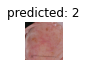

Actual: 2, predicted: 2


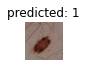

Actual: 0, predicted: 1


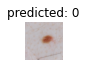

Actual: 0, predicted: 0


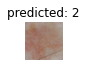

Actual: 2, predicted: 2


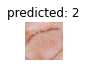

Actual: 2, predicted: 2


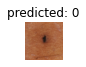

Actual: 0, predicted: 0


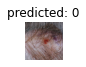

Actual: 0, predicted: 0


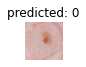

Actual: 0, predicted: 0


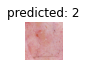

Actual: 2, predicted: 2


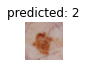

Actual: 2, predicted: 2


In [ ]:
visualize_model(densenet, test_loader, DEVICE, num_images=10)

##### With ADAM

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/Densenet/densenest_wce_adam.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/Densenet'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-8

In [ ]:
densenet = make_densenet(True)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(densenet.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.5, mode="min")

In [ ]:
logging.info('Model:Densenet, LR: 1e-4, LR patience = 7, loss: WCE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8')

Model:Densenet, LR: 1e-4, LR patience = 7, loss: WCE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8


In [ ]:
densenet = train_model(densenet, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.9105, acc: 0.5690, bma: 0.5805
val epoch 1 : loss : 0.7570, acc: 0.7267, bma: 0.6897

Epoch 2/100
----------
train epoch 2 : loss : 0.7446, acc: 0.6570, bma: 0.6704
val epoch 2 : loss : 0.6180, acc: 0.7067, bma: 0.7194

Epoch 3/100
----------
train epoch 3 : loss : 0.7197, acc: 0.6865, bma: 0.6870
val epoch 3 : loss : 0.7017, acc: 0.7267, bma: 0.6497

Epoch 4/100
----------
train epoch 4 : loss : 0.6648, acc: 0.6980, bma: 0.7099
val epoch 4 : loss : 0.5997, acc: 0.7133, bma: 0.7076

Epoch 5/100
----------
train epoch 5 : loss : 0.6755, acc: 0.7075, bma: 0.7061
val epoch 5 : loss : 0.4807, acc: 0.6800, bma: 0.6886

Epoch 6/100
----------
train epoch 6 : loss : 0.6520, acc: 0.7030, bma: 0.7103
val epoch 6 : loss : 0.5495, acc: 0.7000, bma: 0.6504

Epoch 7/100
----------
train epoch 7 : loss : 0.6189, acc: 0.7075, bma: 0.7257
val epoch 7 : loss : 0.5221, acc: 0.7333, bma: 0.6781

Epoch 8/100
----------
train epoch 8 : loss : 0.5907, acc: 0.7

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(densenet, test_loader, DEVICE, criterion)

Test Loss: 0.7558 Acc: 0.7417, BMA: 0.7351
Testing complete in 3m 26s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.7558, acc: 0.7417, bma: 0.7351


Show some results

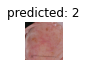

Actual: 2, predicted: 2


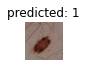

Actual: 0, predicted: 1


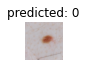

Actual: 0, predicted: 0


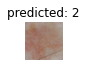

Actual: 2, predicted: 2


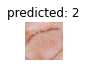

Actual: 2, predicted: 2


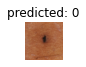

Actual: 0, predicted: 0


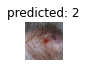

Actual: 0, predicted: 2


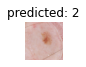

Actual: 0, predicted: 2


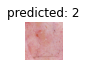

Actual: 2, predicted: 2


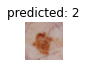

Actual: 2, predicted: 2


In [ ]:
visualize_model(densenet, test_loader, DEVICE, num_images=10)

#### With Sampling + Cross Entropy 

##### With SGD

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/Densenet/densenest_ce_sgd.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/Densenet'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 15

EPOCHS = 100
WD = 1e-8

In [ ]:
densenet = make_densenet(True)

criterion = nn.CrossEntropyLoss() # use cross entropy with balanced training loader, no weights

optimizer = optim.SGD(densenet.parameters(), lr = LR, weight_decay=WD, momentum = 0.9)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.5, mode="min")

In [ ]:
logging.info('Model:Densenet, LR init: 1e-4, LR patience = 7, loss: CE, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-8, momentum = 0.9, with Undersampling')

Model:Densenet, LR init: 1e-4, LR patience = 7, loss: CE, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-8, momentum = 0.9, with Undersampling


In [ ]:
densenet = train_model(densenet, dataloaders_balanced, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.4141, acc: 0.4304, bma: 0.4234
val epoch 1 : loss : 1.0785, acc: 0.4200, bma: 0.3972

Epoch 2/100
----------
train epoch 2 : loss : 0.3875, acc: 0.4554, bma: 0.4533
val epoch 2 : loss : 0.9921, acc: 0.5467, bma: 0.5136

Epoch 3/100
----------
train epoch 3 : loss : 0.3708, acc: 0.5538, bma: 0.5532
val epoch 3 : loss : 0.9262, acc: 0.6067, bma: 0.5462

Epoch 4/100
----------
train epoch 4 : loss : 0.3469, acc: 0.6050, bma: 0.6025
val epoch 4 : loss : 0.9058, acc: 0.5933, bma: 0.5791

Epoch 5/100
----------
train epoch 5 : loss : 0.3470, acc: 0.5761, bma: 0.5786
val epoch 5 : loss : 0.8652, acc: 0.6267, bma: 0.6173

Epoch 6/100
----------
train epoch 6 : loss : 0.3334, acc: 0.5840, bma: 0.5842
val epoch 6 : loss : 0.8734, acc: 0.6000, bma: 0.6017

Epoch 7/100
----------
train epoch 7 : loss : 0.3181, acc: 0.6325, bma: 0.6320
val epoch 7 : loss : 0.8237, acc: 0.6467, bma: 0.6275

Epoch 8/100
----------
train epoch 8 : loss : 0.3204, acc: 0.6

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(densenet, test_loader, DEVICE, criterion)

Test Loss: 0.6613 Acc: 0.7167, BMA: 0.7138
Testing complete in 7m 54s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.6613, acc: 0.7167, bma: 0.7138


Show some results

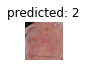

Actual: 2, predicted: 2


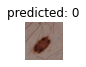

Actual: 0, predicted: 0


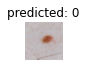

Actual: 0, predicted: 0


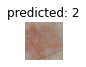

Actual: 2, predicted: 2


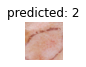

Actual: 2, predicted: 2


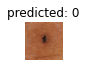

Actual: 0, predicted: 0


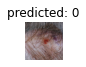

Actual: 0, predicted: 0


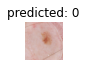

Actual: 0, predicted: 0


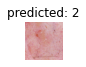

Actual: 2, predicted: 2


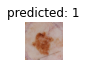

Actual: 2, predicted: 1


In [ ]:
visualize_model(densenet, test_loader, DEVICE, num_images=10)

##### With ADAM

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/Densenet/densenest_ce_adam.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/Densenet'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-8

In [ ]:
densenet = make_densenet(True)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(densenet.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.5, mode="min")

In [ ]:
logging.info('Model:Densenet, LR: 1e-4, LR patience = 7, loss: WCE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8, with sampling')

Model:Densenet, LR: 1e-4, LR patience = 7, loss: WCE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8, with sampling


In [ ]:
densenet = train_model(densenet, dataloaders_balanced, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.3273, acc: 0.6089, bma: 0.6092
val epoch 1 : loss : 0.7826, acc: 0.6400, bma: 0.6821

Epoch 2/100
----------
train epoch 2 : loss : 0.2808, acc: 0.6693, bma: 0.6689
val epoch 2 : loss : 0.6607, acc: 0.7267, bma: 0.6976

Epoch 3/100
----------
train epoch 3 : loss : 0.2866, acc: 0.6877, bma: 0.6836
val epoch 3 : loss : 0.7664, acc: 0.6533, bma: 0.6017

Epoch 4/100
----------
train epoch 4 : loss : 0.2576, acc: 0.7021, bma: 0.7021
val epoch 4 : loss : 0.5749, acc: 0.7533, bma: 0.6726

Epoch 5/100
----------
train epoch 5 : loss : 0.2556, acc: 0.6942, bma: 0.6975
val epoch 5 : loss : 0.6332, acc: 0.7600, bma: 0.6811

Epoch 6/100
----------
train epoch 6 : loss : 0.2430, acc: 0.7100, bma: 0.7113
val epoch 6 : loss : 0.6567, acc: 0.6733, bma: 0.6570

Epoch 7/100
----------
train epoch 7 : loss : 0.2493, acc: 0.7100, bma: 0.7129
val epoch 7 : loss : 0.5323, acc: 0.7533, bma: 0.7247

Epoch 8/100
----------
train epoch 8 : loss : 0.2307, acc: 0.7

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(densenet, test_loader, DEVICE, criterion)

Test Loss: 0.6837 Acc: 0.7567, BMA: 0.7527
Testing complete in 3m 26s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.6837, acc: 0.7567, bma: 0.7527


Show some results

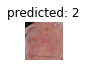

Actual: 2, predicted: 2


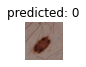

Actual: 0, predicted: 0


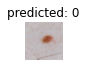

Actual: 0, predicted: 0


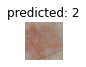

Actual: 2, predicted: 2


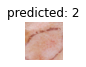

Actual: 2, predicted: 2


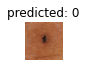

Actual: 0, predicted: 0


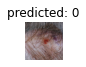

Actual: 0, predicted: 0


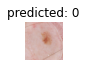

Actual: 0, predicted: 0


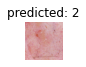

Actual: 2, predicted: 2


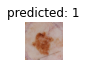

Actual: 2, predicted: 1


In [ ]:
visualize_model(densenet, test_loader, DEVICE, num_images=10)

## 2. Vision Transformer 

#### With Focal Loss

##### With SGD

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/Densenet/vit_fl_sgd.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/VIT'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 5
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-8

In [ ]:
vit  = make_vitb16(True)

criterion = FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True)

optimizer = optim.SGD(vit.parameters(), lr = LR, weight_decay=WD, momentum = 0.9)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

In [ ]:
logging.info('Model: VIT, Base LR: 1e-4, LR patience = 5, loss: Focal, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-8, momentum = 0.9')

Model: VIT, Base LR: 1e-4, LR patience = 5, loss: Focal, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-8, momentum = 0.9


In [ ]:
vit = train_model(vit, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.4493, acc: 0.4325, bma: 0.4686
val epoch 1 : loss : 0.6122, acc: 0.4667, bma: 0.4786

Epoch 2/100
----------
train epoch 2 : loss : 0.3597, acc: 0.5755, bma: 0.5977
val epoch 2 : loss : 0.5246, acc: 0.5733, bma: 0.5731

Epoch 3/100
----------
train epoch 3 : loss : 0.3207, acc: 0.6075, bma: 0.6498
val epoch 3 : loss : 0.4761, acc: 0.6333, bma: 0.6162

Epoch 4/100
----------
train epoch 4 : loss : 0.2976, acc: 0.6160, bma: 0.6603
val epoch 4 : loss : 0.4614, acc: 0.6600, bma: 0.6360

Epoch 5/100
----------
train epoch 5 : loss : 0.2812, acc: 0.6400, bma: 0.6766
val epoch 5 : loss : 0.4039, acc: 0.6333, bma: 0.6477

Epoch 6/100
----------
train epoch 6 : loss : 0.2697, acc: 0.6475, bma: 0.7002
val epoch 6 : loss : 0.4117, acc: 0.6333, bma: 0.6067

Epoch 7/100
----------
train epoch 7 : loss : 0.2629, acc: 0.6605, bma: 0.7050
val epoch 7 : loss : 0.4039, acc: 0.6533, bma: 0.6391

Epoch 8/100
----------
train epoch 8 : loss : 0.2476, acc: 0.6

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(vit, test_loader, DEVICE, criterion)

Test Loss: 0.3217 Acc: 0.6667, BMA: 0.6729
Testing complete in 3m 26s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.3217, acc: 0.6667, bma: 0.6729


Show some results

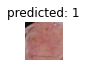

Actual: 2, predicted: 1


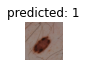

Actual: 0, predicted: 1


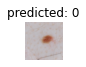

Actual: 0, predicted: 0


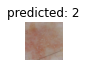

Actual: 2, predicted: 2


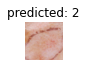

Actual: 2, predicted: 2


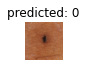

Actual: 0, predicted: 0


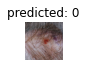

Actual: 0, predicted: 0


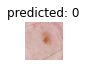

Actual: 0, predicted: 0


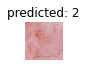

Actual: 2, predicted: 2


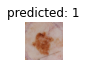

Actual: 2, predicted: 1


In [ ]:
visualize_model(vit, test_loader, DEVICE, num_images=10)

In [ ]:
torch.save(vit.state_dict(), '/content/drive/MyDrive/MRTYUTeam/classification_checkpoints/vit_fl_sgd.pth')

##### With ADAM

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/VIT/vit_fl_adam.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/VIT'

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 5
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-8

In [ ]:
vit  = make_vitb16(True)

criterion = FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True)

optimizer =  optim.Adam(vit.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.5, mode="min")

In [ ]:
logging.info('Model:VIT, LR: 1e-4, LR patience = 5, loss: Focal, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8')

Model:VIT, LR: 1e-4, LR patience = 5, loss: Focal, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8


In [ ]:
vit = train_model(vit, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.5068, acc: 0.3955, bma: 0.4203
val epoch 1 : loss : 0.6895, acc: 0.6000, bma: 0.5863

Epoch 2/100
----------
train epoch 2 : loss : 0.4535, acc: 0.4310, bma: 0.4519
val epoch 2 : loss : 0.5472, acc: 0.5400, bma: 0.4849

Epoch 3/100
----------
train epoch 3 : loss : 0.4314, acc: 0.4745, bma: 0.4976
val epoch 3 : loss : 0.4808, acc: 0.3733, bma: 0.3932

Epoch 4/100
----------
train epoch 4 : loss : 0.4441, acc: 0.4500, bma: 0.4824
val epoch 4 : loss : 0.6007, acc: 0.6000, bma: 0.5392

Epoch 5/100
----------
train epoch 5 : loss : 0.4182, acc: 0.4575, bma: 0.5061
val epoch 5 : loss : 0.4920, acc: 0.4600, bma: 0.5256

Epoch 6/100
----------
train epoch 6 : loss : 0.4044, acc: 0.4990, bma: 0.5426
val epoch 6 : loss : 0.4524, acc: 0.5267, bma: 0.5689

Epoch 7/100
----------
train epoch 7 : loss : 0.4038, acc: 0.4615, bma: 0.5100
val epoch 7 : loss : 0.5816, acc: 0.6133, bma: 0.6183

Epoch 8/100
----------
train epoch 8 : loss : 0.3860, acc: 0.5

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(vit, test_loader, DEVICE, criterion)

Test Loss: 0.4889 Acc: 0.6267, BMA: 0.6554
Testing complete in 3m 28s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.4889, acc: 0.6267, bma: 0.6554


Show some results

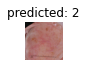

Actual: 2, predicted: 2


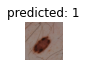

Actual: 0, predicted: 1


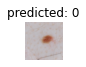

Actual: 0, predicted: 0


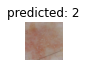

Actual: 2, predicted: 2


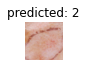

Actual: 2, predicted: 2


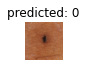

Actual: 0, predicted: 0


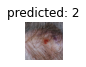

Actual: 0, predicted: 2


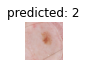

Actual: 0, predicted: 2


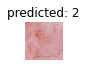

Actual: 2, predicted: 2


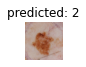

Actual: 2, predicted: 2


In [ ]:
visualize_model(vit, test_loader, DEVICE, num_images=10)

#### With Weighted Cross Entropy 

##### With SGD

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/VIT/vit_wce_sgd.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/VIT'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 5
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-8

In [ ]:
vit = make_vitb16(True)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.SGD(vit.parameters(), lr = LR, weight_decay=WD, momentum = 0.9)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

In [ ]:
logging.info('Model: ViT, LR init: 1e-4, LR patience = 5, loss: WCE, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-8, momentum = 0.9')

Model: ViT, LR init: 1e-4, LR patience = 5, loss: WCE, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-8, momentum = 0.9


In [ ]:
vit = train_model(vit, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 1.0170, acc: 0.5190, bma: 0.4669
val epoch 1 : loss : 0.9795, acc: 0.5800, bma: 0.5103

Epoch 2/100
----------
train epoch 2 : loss : 0.8600, acc: 0.6215, bma: 0.6151
val epoch 2 : loss : 0.7985, acc: 0.6800, bma: 0.6415

Epoch 3/100
----------
train epoch 3 : loss : 0.7842, acc: 0.6525, bma: 0.6549
val epoch 3 : loss : 0.7636, acc: 0.7000, bma: 0.6521

Epoch 4/100
----------
train epoch 4 : loss : 0.7481, acc: 0.6710, bma: 0.6686
val epoch 4 : loss : 0.6945, acc: 0.6600, bma: 0.6370

Epoch 5/100
----------
train epoch 5 : loss : 0.7167, acc: 0.6915, bma: 0.6993
val epoch 5 : loss : 0.7173, acc: 0.6933, bma: 0.6474

Epoch 6/100
----------
train epoch 6 : loss : 0.7159, acc: 0.6770, bma: 0.6875
val epoch 6 : loss : 0.6775, acc: 0.7067, bma: 0.6706

Epoch 7/100
----------
train epoch 7 : loss : 0.7025, acc: 0.6850, bma: 0.6939
val epoch 7 : loss : 0.6421, acc: 0.6933, bma: 0.6762

Epoch 8/100
----------
train epoch 8 : loss : 0.7299, acc: 0.6

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(vit, test_loader, DEVICE, criterion)

Test Loss: 0.7611 Acc: 0.6383, BMA: 0.6802
Testing complete in 3m 24s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.7611, acc: 0.6383, bma: 0.6802


Show some results

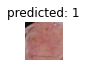

Actual: 2, predicted: 1


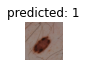

Actual: 0, predicted: 1


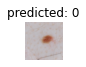

Actual: 0, predicted: 0


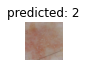

Actual: 2, predicted: 2


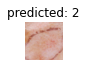

Actual: 2, predicted: 2


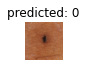

Actual: 0, predicted: 0


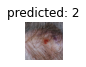

Actual: 0, predicted: 2


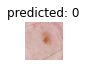

Actual: 0, predicted: 0


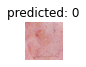

Actual: 2, predicted: 0


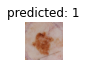

Actual: 2, predicted: 1


In [ ]:
visualize_model(vit, test_loader, DEVICE, num_images=10)

##### With ADAM

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/VIT/vit_wce_adam.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/VIT'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 10
ES_PATIENCE = 15

EPOCHS = 100
WD = 0

In [ ]:
vit =  make_vitb16(True)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(vit.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.5, mode="min")

In [ ]:
logging.info('Model: Vit, LR: 1e-4, LR patience = 10, loss: WCE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 0')

In [ ]:
vit = train_model(vit, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.9170, acc: 0.5705, bma: 0.5469
val epoch 1 : loss : 0.7523, acc: 0.6600, bma: 0.6060

Epoch 2/100
----------
train epoch 2 : loss : 0.7318, acc: 0.6700, bma: 0.6847
val epoch 2 : loss : 0.6291, acc: 0.6867, bma: 0.7051

Epoch 3/100
----------
train epoch 3 : loss : 0.6878, acc: 0.6940, bma: 0.7028
val epoch 3 : loss : 0.5933, acc: 0.7267, bma: 0.7249

Epoch 4/100
----------
train epoch 4 : loss : 0.6145, acc: 0.7150, bma: 0.7358
val epoch 4 : loss : 0.6721, acc: 0.7000, bma: 0.6399

Epoch 5/100
----------
train epoch 5 : loss : 0.5688, acc: 0.7495, bma: 0.7594
val epoch 5 : loss : 0.5800, acc: 0.7267, bma: 0.7107

Epoch 6/100
----------
train epoch 6 : loss : 0.5461, acc: 0.7515, bma: 0.7658
val epoch 6 : loss : 0.5449, acc: 0.7333, bma: 0.7155

Epoch 7/100
----------
train epoch 7 : loss : 0.5232, acc: 0.7575, bma: 0.7745
val epoch 7 : loss : 0.5513, acc: 0.7267, bma: 0.7222

Epoch 8/100
----------
train epoch 8 : loss : 0.4507, acc: 0.7

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(vit, test_loader, DEVICE, criterion)

Test Loss: 0.6922 Acc: 0.7333, BMA: 0.7289
Testing complete in 3m 25s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.6922, acc: 0.7333, bma: 0.7289


Show some results

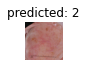

Actual: 2, predicted: 2


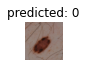

Actual: 0, predicted: 0


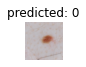

Actual: 0, predicted: 0


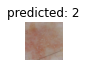

Actual: 2, predicted: 2


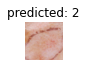

Actual: 2, predicted: 2


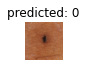

Actual: 0, predicted: 0


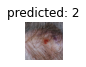

Actual: 0, predicted: 2


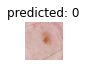

Actual: 0, predicted: 0


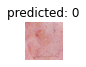

Actual: 2, predicted: 0


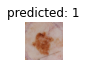

Actual: 2, predicted: 1


In [ ]:
visualize_model(vit, test_loader, DEVICE, num_images=10)

## 3. ConvNext

#### With Focal Loss

##### With SGD

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/Tensorboard_class/convnext/convnext_fl_sgd.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/Tensorboard_class/convnext'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 5
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-6

In [ ]:
convnext  = make_convnext(True)

criterion = FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True)

optimizer = optim.SGD(convnext.parameters(), lr = LR, weight_decay=WD, momentum = 0.9)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

In [ ]:
logging.info('Model: ConvNext, Base LR: 1e-4, LR patience = 5, loss: Focal, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-6, momentum = 0.9')

Model: ConvNext, Base LR: 1e-4, LR patience = 5, loss: Focal, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-6, momentum = 0.9


In [ ]:
convnext = train_model(convnext, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.4504, acc: 0.4585, bma: 0.4780
val epoch 1 : loss : 0.5211, acc: 0.4200, bma: 0.4558

Epoch 2/100
----------
train epoch 2 : loss : 0.3886, acc: 0.5340, bma: 0.5683
val epoch 2 : loss : 0.4655, acc: 0.5267, bma: 0.5452

Epoch 3/100
----------
train epoch 3 : loss : 0.3556, acc: 0.5505, bma: 0.5950
val epoch 3 : loss : 0.4852, acc: 0.6000, bma: 0.6112

Epoch 4/100
----------
train epoch 4 : loss : 0.3315, acc: 0.5720, bma: 0.6297
val epoch 4 : loss : 0.4734, acc: 0.6267, bma: 0.6015

Epoch 5/100
----------
train epoch 5 : loss : 0.3227, acc: 0.6090, bma: 0.6447
val epoch 5 : loss : 0.4255, acc: 0.6267, bma: 0.6261

Epoch 6/100
----------
train epoch 6 : loss : 0.3095, acc: 0.5970, bma: 0.6434
val epoch 6 : loss : 0.4275, acc: 0.6200, bma: 0.6082

Epoch 7/100
----------
train epoch 7 : loss : 0.2894, acc: 0.6285, bma: 0.6758
val epoch 7 : loss : 0.4338, acc: 0.6533, bma: 0.6737

Epoch 8/100
----------
train epoch 8 : loss : 0.2774, acc: 0.6

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(convnext, test_loader, DEVICE, criterion)

Test Loss: 0.3341 Acc: 0.6167, BMA: 0.6600
Testing complete in 6m 15s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.3341, acc: 0.6167, bma: 0.6600


Show some results

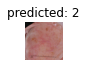

Actual: 2, predicted: 2


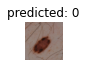

Actual: 0, predicted: 0


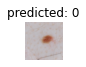

Actual: 0, predicted: 0


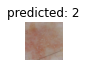

Actual: 2, predicted: 2


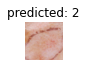

Actual: 2, predicted: 2


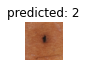

Actual: 0, predicted: 2


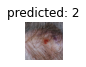

Actual: 0, predicted: 2


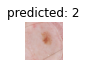

Actual: 0, predicted: 2


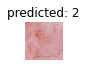

Actual: 2, predicted: 2


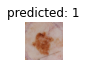

Actual: 2, predicted: 1


In [ ]:
visualize_model(convnext, test_loader, DEVICE, num_images=10)

##### With ADAM

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/Tensorboard_class/convnext/convnext_fl_adam.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/Tensorboard_class/convnext'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 5
ES_PATIENCE = 10

EPOCHS = 100
WD = 0

In [ ]:
convnext  = make_convnext(True)

criterion = FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True)

optimizer = optim.Adam(convnext.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

In [ ]:
logging.info('Model: ConvNext, Base LR: 1e-4, LR patience = 5, loss: Focal, optim: ADAM, lr_sched: ReduceOnPlat, WD = 0')

Model: ConvNext, Base LR: 1e-4, LR patience = 5, loss: Focal, optim: ADAM, lr_sched: ReduceOnPlat, WD = 0


In [ ]:
convnext = train_model(convnext, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.4003, acc: 0.4985, bma: 0.5397
val epoch 1 : loss : 0.3881, acc: 0.6933, bma: 0.6794

Epoch 2/100
----------
train epoch 2 : loss : 0.2854, acc: 0.6165, bma: 0.6737
val epoch 2 : loss : 0.3332, acc: 0.6867, bma: 0.6919

Epoch 3/100
----------
train epoch 3 : loss : 0.2487, acc: 0.6760, bma: 0.7121
val epoch 3 : loss : 0.2619, acc: 0.6333, bma: 0.6761

Epoch 4/100
----------
train epoch 4 : loss : 0.2010, acc: 0.6950, bma: 0.7510
val epoch 4 : loss : 0.3824, acc: 0.7333, bma: 0.6730

Epoch 5/100
----------
train epoch 5 : loss : 0.1898, acc: 0.7175, bma: 0.7647
val epoch 5 : loss : 0.2215, acc: 0.7800, bma: 0.7938

Epoch 6/100
----------
train epoch 6 : loss : 0.1495, acc: 0.7740, bma: 0.8070
val epoch 6 : loss : 0.1661, acc: 0.7667, bma: 0.8016

Epoch 7/100
----------
train epoch 7 : loss : 0.1421, acc: 0.7835, bma: 0.8233
val epoch 7 : loss : 0.2359, acc: 0.7533, bma: 0.7689

Epoch 8/100
----------
train epoch 8 : loss : 0.1402, acc: 0.7

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(convnext, test_loader, DEVICE, criterion)

Test Loss: 0.3410 Acc: 0.7350, BMA: 0.7311
Testing complete in 3m 26s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.3410, acc: 0.7350, bma: 0.7311


Show some results

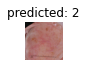

Actual: 2, predicted: 2


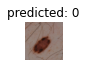

Actual: 0, predicted: 0


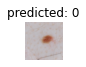

Actual: 0, predicted: 0


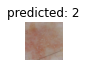

Actual: 2, predicted: 2


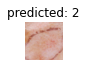

Actual: 2, predicted: 2


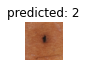

Actual: 0, predicted: 2


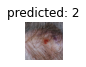

Actual: 0, predicted: 2


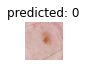

Actual: 0, predicted: 0


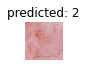

Actual: 2, predicted: 2


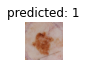

Actual: 2, predicted: 1


In [ ]:
visualize_model(convnext, test_loader, DEVICE, num_images=10)

#### With Weighted Cross Entropy 

##### With SGD

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/Tensorboard_class/convnext/convnext_wce_sgd.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/Tensorboard_class/convnext'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 5
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-8

In [ ]:
convnext = make_convnext(True)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.SGD(convnext.parameters(), lr = LR, weight_decay=WD, momentum = 0.9)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

In [ ]:
logging.info('Model: ConvNext, LR init: 1e-4, LR patience = 5, loss: WCE, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-8, momentum = 0.9')

Model: ConvNext, LR init: 1e-4, LR patience = 5, loss: WCE, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-8, momentum = 0.9


In [ ]:
vit = train_model(convnext, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 1.0172, acc: 0.5220, bma: 0.4672
val epoch 1 : loss : 0.8820, acc: 0.5733, bma: 0.5646

Epoch 2/100
----------
train epoch 2 : loss : 0.9104, acc: 0.5680, bma: 0.5678
val epoch 2 : loss : 0.8400, acc: 0.6667, bma: 0.6352

Epoch 3/100
----------
train epoch 3 : loss : 0.8111, acc: 0.6260, bma: 0.6353
val epoch 3 : loss : 0.7983, acc: 0.6600, bma: 0.6697

Epoch 4/100
----------
train epoch 4 : loss : 0.7601, acc: 0.6555, bma: 0.6611
val epoch 4 : loss : 0.6760, acc: 0.6867, bma: 0.6846

Epoch 5/100
----------
train epoch 5 : loss : 0.7368, acc: 0.6515, bma: 0.6692
val epoch 5 : loss : 0.6426, acc: 0.7133, bma: 0.7017

Epoch 6/100
----------
train epoch 6 : loss : 0.7249, acc: 0.6710, bma: 0.6835
val epoch 6 : loss : 0.6053, acc: 0.6867, bma: 0.6998

Epoch 7/100
----------
train epoch 7 : loss : 0.6643, acc: 0.6830, bma: 0.7135
val epoch 7 : loss : 0.7316, acc: 0.6400, bma: 0.6510

Epoch 8/100
----------
train epoch 8 : loss : 0.6801, acc: 0.6

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(convnext, test_loader, DEVICE, criterion)

Test Loss: 0.6937 Acc: 0.7000, BMA: 0.7182
Testing complete in 3m 30s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Show some results

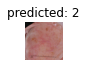

Actual: 2, predicted: 2


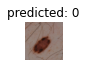

Actual: 0, predicted: 0


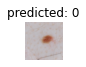

Actual: 0, predicted: 0


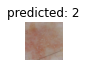

Actual: 2, predicted: 2


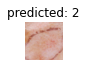

Actual: 2, predicted: 2


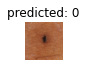

Actual: 0, predicted: 0


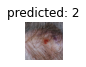

Actual: 0, predicted: 2


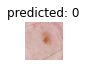

Actual: 0, predicted: 0


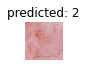

Actual: 2, predicted: 2


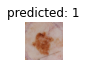

Actual: 2, predicted: 1


In [ ]:
visualize_model(convnext, test_loader, DEVICE, num_images=10)

##### With ADAM

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/Tensorboard_class/convnext/convnext_wce_adam.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/Tensorboard_class/convnext'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 5
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-8

In [ ]:
convnext =  make_convnext(True)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(convnext.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.5, mode="min")

In [ ]:
logging.info('Model: ConvNext, LR: 1e-4, LR patience = 5, loss: WCE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8')

Model: ConvNext, LR: 1e-4, LR patience = 5, loss: WCE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8


In [ ]:
convnext = train_model(convnext, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.8891, acc: 0.5585, bma: 0.5710
val epoch 1 : loss : 0.5759, acc: 0.7133, bma: 0.6927

Epoch 2/100
----------
train epoch 2 : loss : 0.6700, acc: 0.6795, bma: 0.7022
val epoch 2 : loss : 0.5313, acc: 0.7867, bma: 0.7397

Epoch 3/100
----------
train epoch 3 : loss : 0.5630, acc: 0.7460, bma: 0.7712
val epoch 3 : loss : 0.4581, acc: 0.8267, bma: 0.7890

Epoch 4/100
----------
train epoch 4 : loss : 0.5171, acc: 0.7730, bma: 0.7895
val epoch 4 : loss : 0.4125, acc: 0.8000, bma: 0.8330

Epoch 5/100
----------
train epoch 5 : loss : 0.4146, acc: 0.8025, bma: 0.8170
val epoch 5 : loss : 0.3928, acc: 0.7933, bma: 0.8150

Epoch 6/100
----------
train epoch 6 : loss : 0.4029, acc: 0.8145, bma: 0.8282
val epoch 6 : loss : 0.5040, acc: 0.8133, bma: 0.7968

Epoch 7/100
----------
train epoch 7 : loss : 0.3235, acc: 0.8520, bma: 0.8718
val epoch 7 : loss : 0.4815, acc: 0.8200, bma: 0.7742

Epoch 8/100
----------
train epoch 8 : loss : 0.3193, acc: 0.8

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(convnext, test_loader, DEVICE, criterion)

Test Loss: 0.7113 Acc: 0.6367, BMA: 0.7197
Testing complete in 3m 26s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.7113, acc: 0.6367, bma: 0.7197


Show some results

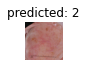

Actual: 2, predicted: 2


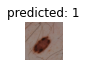

Actual: 0, predicted: 1


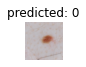

Actual: 0, predicted: 0


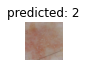

Actual: 2, predicted: 2


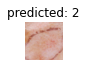

Actual: 2, predicted: 2


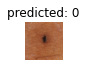

Actual: 0, predicted: 0


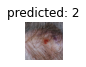

Actual: 0, predicted: 2


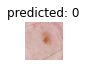

Actual: 0, predicted: 0


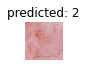

Actual: 2, predicted: 2


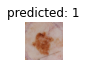

Actual: 2, predicted: 1


In [ ]:
visualize_model(convnext, test_loader, DEVICE, num_images=10)